In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
warnings.filterwarnings('ignore')

**Loss and $\tau_f$ against iteration**

In [3]:
L63_data_path = '../data/L63-trajectories'
save_folder = '../data/nn_adaptive_lr_s'
D_r, N = 300, 20000
L0, L1 = 0.4, 3.5 
beta = 4e-5
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float64)
test = np.load(f'{L63_data_path}/test.npy')[:500, :, :800].astype(np.float64)
model = srnn.SurrogateModel_NN(3, 300, save_folder=save_folder)

idx = lambda x: ~np.isnan(x)

In [22]:
tau_f = np.load(f'{model.save_folder}/tau_f_se.npy')
loss = np.load(f'{model.save_folder}/loss.npy')
iteration = np.load(f'{model.save_folder}/iteration.npy')

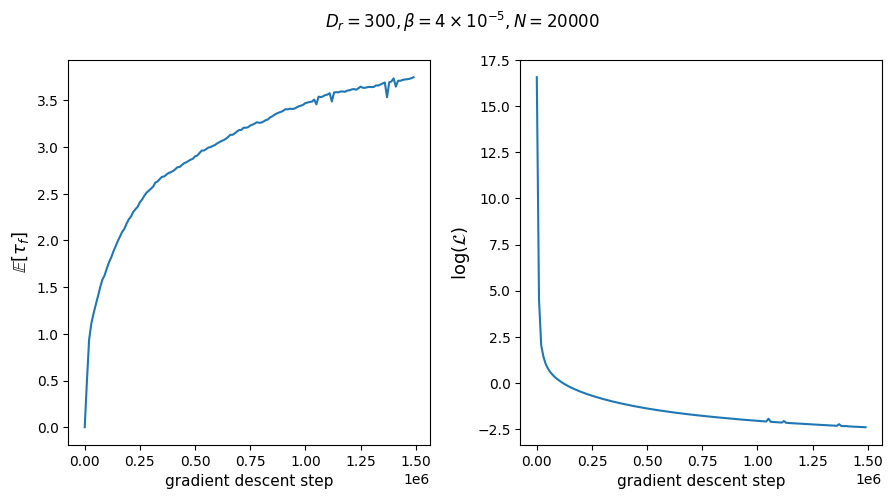

In [21]:
fig = plt.figure(figsize=(10.5, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
j = idx(tau_f)
ax.plot(iteration[j], tau_f[j])
ax1.plot(iteration[j], np.log(loss[j]))
ax.set_xlabel('gradient descent step', fontsize=11)
ax1.set_xlabel('gradient descent step', fontsize=11)
ax.set_ylabel(r'$\mathbb{E}[\tau_f]$', fontsize=13)
ax1.set_ylabel(r'$\log(\mathcal{L})$', fontsize=13)
fig.subplots_adjust(wspace=.25)
fig.suptitle(r'$D_r=300, \beta=4\times10^{-5}, N=20000$')
plt.savefig('../data/plots/nn-tau_f-loss.png', dpi=300, bbox_inches='tight')

In [24]:
tau_f[j][-1]

3.7488360000000003

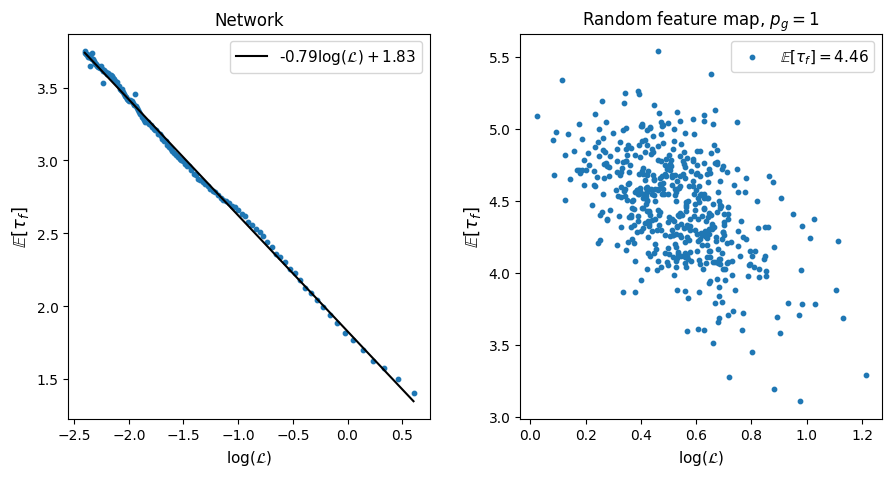

In [100]:
fig = plt.figure(figsize=(10.5, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

x, y = np.log(loss[j])[6:], tau_f[j][6:]
ax.scatter(x, y, s=10)
res = stats.linregress(x, y)
a, b = res.slope, res.intercept
ax.plot(x, a*x+b, c='black', label=f'{a:.2f}'+r'$\log(\mathcal{L})+$'+f'{b:.2f}')
ax.locator_params(nbins=10, axis='x')
ax.legend(fontsize=11)
ax.set_xlabel('$\log(\mathcal{L})$', fontsize=11)
ax.set_ylabel(r'$\mathbb{E}[\tau_f]$', fontsize=13)
ax.set_title('Network')


bsa = sr1.BatchStrategyAnalyzer_SMLR('../data/standard-multi-valid')
data = bsa.get_data()
x, y = np.log(data['train_loss']), data['tau_f_se']
ax1.scatter(x, y, s=10, label=r'$\mathbb{E}[\tau_f]=$'+f'{y.mean():.2f}')
res = stats.linregress(x, y)
a, b = res.slope, res.intercept
# ax1.plot(x, a*x+b, c='black', label=f'{a:.2f}'+r'$\log(\mathcal{L})+$'+f'{b:.2f}')
ax1.legend(fontsize=11)
ax1.set_xlabel('$\log(\mathcal{L})$', fontsize=11)
ax1.set_ylabel(r'$\mathbb{E}[\tau_f]$', fontsize=13)
ax1.set_title('Random feature map, $p_g=1$')
fig.subplots_adjust(wspace=.25)
# fig.suptitle(r'$D_r=300, \beta=4\times10^{-5}, N=20000$')
plt.savefig('../data/plots/scatter-tau_f-loss.png', dpi=300, bbox_inches='tight')

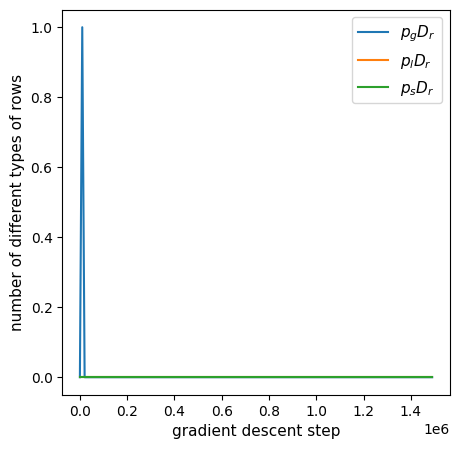

In [123]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

data = model.read()
ax.plot(iteration[j], D_r*data['good_rows_W_in'][j], label=r'$p_gD_r$')
ax.plot(iteration[j], D_r*data['linear_rows_W_in'][j], label=r'$p_lD_r$')
ax.plot(iteration[j], D_r*data['extreme_rows_W_in'][j], label=r'$p_sD_r$')
ax.legend(fontsize=11)
ax.set_ylabel('number of different types of rows', fontsize=11)
ax.set_xlabel('gradient descent step', fontsize=11)
plt.savefig('../data/plots/no-structure-formation.png', dpi=300, bbox_inches='tight')

Time taken by count_row_types is 3.8795 seconds


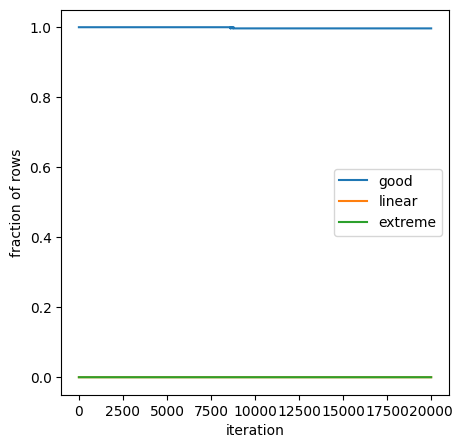

In [129]:
save_folder='../data/rf-start-lr1'
model1 = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
# model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
# model.learn(train[:, :20000], 20000, 1e-4, batch_size='GD', log_interval=10, save_interval=10)
model1.count_row_types(1, L0, L1, train.T)

Time taken by count_row_types is 2.0284 seconds


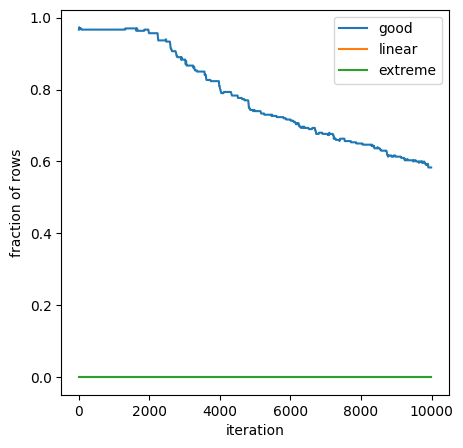

In [136]:
save_folder='../data/rf-start-lr2'
model2 = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model2.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
# model2.learn(train[:, :20000], 10000, 1e-3, batch_size='GD', log_interval=10, save_interval=10)
model2.count_row_types(1, L0, L1, train.T)

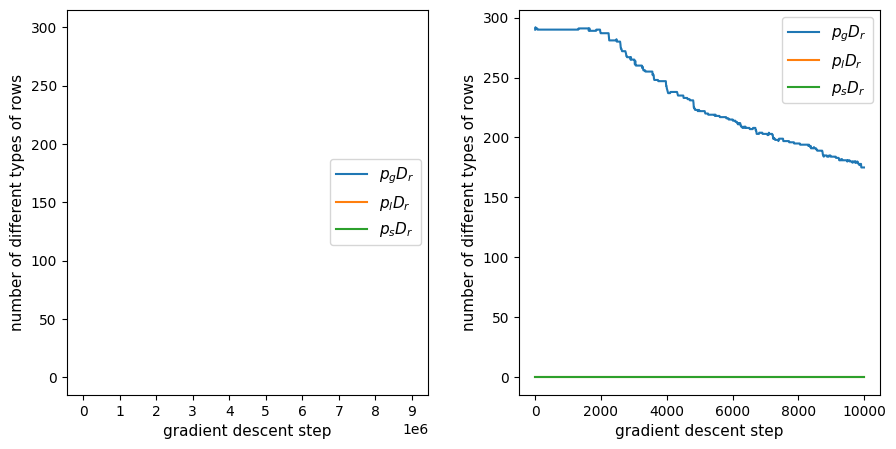

In [138]:
fig = plt.figure(figsize=(10.5, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

model1 = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder='../data/nn_rf_tiny_lr')
data1 = model1.read()
data2 = model2.read()

x = data1['iteration']
ax.plot(x, D_r*data1['good_rows_W_in'], label=r'$p_gD_r$')
ax.plot(x, D_r*data1['linear_rows_W_in'], label=r'$p_lD_r$')
ax.plot(x, D_r*data1['extreme_rows_W_in'], label=r'$p_sD_r$')
ax.locator_params(nbins=10, axis='x')
ax.legend(fontsize=11)
ax.set_ylabel('number of different types of rows', fontsize=11)
ax.set_xlabel('gradient descent step', fontsize=11)

x = data2['iteration']
ax1.plot(x, D_r*data2['good_rows_W_in'], label=r'$p_gD_r$')
ax1.plot(x, D_r*data2['linear_rows_W_in'], label=r'$p_lD_r$')
ax1.plot(x, D_r*data2['extreme_rows_W_in'], label=r'$p_sD_r$')
ax1.locator_params(nbins=10, axis='x')
ax1.legend(fontsize=11)
ax1.set_ylabel('number of different types of rows', fontsize=11)
ax1.set_xlabel('gradient descent step', fontsize=11)
fig.subplots_adjust(wspace=.25)
# fig.suptitle(r'$D_r=300, \beta=4\times10^{-5}, N=20000$')
plt.savefig('../data/plots/strcture-deletion.png', dpi=300, bbox_inches='tight')

Time taken by count_row_types is 23.9808 seconds


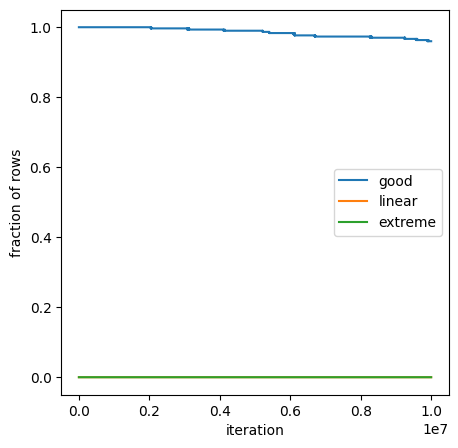

In [140]:
model1.count_row_types(10, L0, L1, train.T)

In [ ]:
model_tlr = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder='../data/nn_rf_tiny_lr')
model_tlr.compute_tau_f(100, train, test, end=100000)

working on index #0
Time taken by compute_tau_f_ is 6.9513 seconds
working on index #10000
Time taken by compute_tau_f_ is 6.9153 seconds
working on index #20000
Time taken by compute_tau_f_ is 6.8770 seconds
working on index #30000
Time taken by compute_tau_f_ is 6.7555 seconds
working on index #40000
Time taken by compute_tau_f_ is 6.7745 seconds
working on index #50000
Time taken by compute_tau_f_ is 6.8763 seconds
working on index #60000
Time taken by compute_tau_f_ is 6.8485 seconds
working on index #70000
Time taken by compute_tau_f_ is 6.8027 seconds
working on index #80000
Time taken by compute_tau_f_ is 6.7311 seconds
working on index #90000
Time taken by compute_tau_f_ is 6.7297 seconds
working on index #100000
Time taken by compute_tau_f_ is 6.8069 seconds
working on index #110000
Time taken by compute_tau_f_ is 6.7786 seconds
working on index #120000
Time taken by compute_tau_f_ is 6.7266 seconds
working on index #130000
Time taken by compute_tau_f_ is 6.7237 seconds
workin

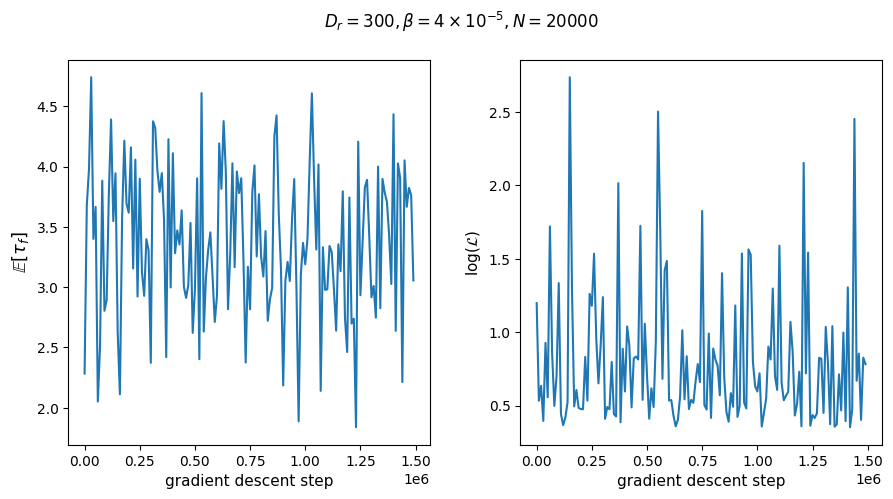

In [7]:
tau_f = np.load(f'{model_tlr.save_folder}/tau_f_se.npy')
loss = np.load(f'{model_tlr.save_folder}/loss.npy')
iteration = np.load(f'{model_tlr.save_folder}/iteration.npy')

fig = plt.figure(figsize=(10.5, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
j = idx(tau_f)
ax.plot(iteration[j], tau_f[j])
ax1.plot(iteration[j], np.log(loss[j]))
ax.set_xlabel('gradient descent step', fontsize=11)
ax1.set_xlabel('gradient descent step', fontsize=11)
ax.set_ylabel(r'$\mathbb{E}[\tau_f]$', fontsize=13)
ax1.set_ylabel(r'$\log(\mathcal{L})$', fontsize=11)
fig.subplots_adjust(wspace=.25)
fig.suptitle(r'$D_r=300, \beta=4\times10^{-5}, N=20000$')
plt.savefig('../data/plots/nn-rf-tiny-lrtau_f-loss.png', dpi=300, bbox_inches='tight')

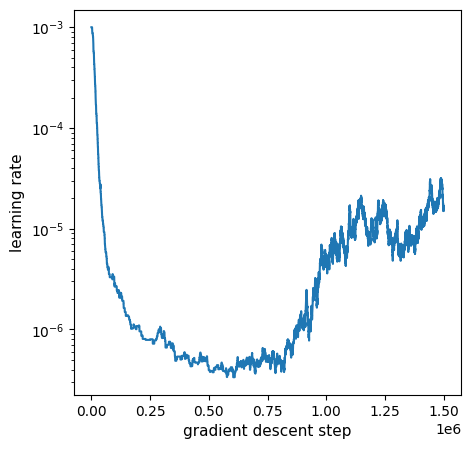

In [33]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
model = srnn.SurrogateModel_NN(3, 300, save_folder=save_folder)
data = model.read()
ax.semilogy(data['iteration'], (data['learning_rate']))
ax.set_xlabel('gradient descent step', fontsize=11)
ax.set_ylabel(r'learning rate', fontsize=11)
ax.locator_params(nbins=8, axis='x')
plt.savefig('../data/plots/adaptive-lr-simple.png', dpi=300, bbox_inches='tight')